In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx
import utils

In [2]:
from collections import defaultdict
from tqdm import tqdm

In [3]:
CATEGORIES = [
    "wordnet_association_108049401",
    "wordnet_authorization_101138670",
    "wordnet_ban_107255401",
    "wordnet_case_law_106535035",
    "wordnet_civil_liberty_113995662",
    "wordnet_code_of_conduct_105668095",
    "wordnet_common_law_108453722",
    "wordnet_company_108058098",
    "wordnet_contract_106520944",
    "wordnet_cooperative_101100877",
    "wordnet_corporation_108059412",
    "wordnet_court_108329453",
    "wordnet_criminal_record_106490173",
    "wordnet_decree_106539770",
    "wordnet_delegating_101140839",
    "wordnet_directive_107170080",
    "wordnet_exemption_100213903",
    "wordnet_foundation_108406486",
    "wordnet_indebtedness_114490319",
    "wordnet_interdiction_107255299",
    "wordnet_judge_110225219",
    "wordnet_judiciary_108166187",
    "wordnet_law_106532330",
    "wordnet_law_108441203",
    "wordnet_lawyer_110249950",
    "wordnet_legal_code_106667792",
    "wordnet_legal_document_106479665",
    "wordnet_legislation_106535222",
    "wordnet_legislative_act_106564387",
    "wordnet_legislature_108163273",
    "wordnet_liability_114530403",
    "wordnet_liberty_113994456",
    "wordnet_liberty_113996061",
    "wordnet_limited_company_108185211",
    "wordnet_mandate_106556481",
    "wordnet_obligation_106773150",
    "wordnet_party_110402824",
    "wordnet_permission_106689297",
    "wordnet_pleading_106559365",
    "wordnet_prerogative_105178715",
    "wordnet_privilege_105158296",
    "wordnet_privilege_105179567",
    "wordnet_proclamation_101266491",
    "wordnet_prohibition_106542047",
    "wordnet_right_104850341",
    "wordnet_right_105174653",
    "wordnet_right_113341756",
    "wordnet_treaty_106773434",
    "wordnet_written_agreement_106771653",
]

In [4]:
RESOURCE_PREFIX = 'http://yago-knowledge.org/resource/'

In [5]:
def get_subclasses_number(category_name, filter_wikicat=False):
    query = """SELECT DISTINCT (count(distinct ?subCategory) as ?count) WHERE {
        ?subCategory rdfs:subClassOf <%s%s> .
        ?entity rdf:type ?subCategory .""" % (RESOURCE_PREFIX, category_name)
    if filter_wikicat:
        query += 'FILTER (!regex(str(?subCategory), "wikicat"))}'
    else:
        query += '}'
    response = utils.query_sparql(query, utils.YAGO_ENPOINT_URL)
    return response[1][0]

In [6]:
for category in CATEGORIES:
    print category, get_subclasses_number(category), get_subclasses_number(category, True)

wordnet_association_108049401 208 9
wordnet_authorization_101138670 1 1
wordnet_ban_107255401 0 0
wordnet_case_law_106535035 0 0
wordnet_civil_liberty_113995662 1 0
wordnet_code_of_conduct_105668095 1 0
wordnet_common_law_108453722 0 0
wordnet_company_108058098 8411 21
wordnet_contract_106520944 2 1
wordnet_cooperative_101100877 62 0
wordnet_corporation_108059412 52 1
wordnet_court_108329453 166 6
wordnet_criminal_record_106490173 1 0
wordnet_decree_106539770 3 3
wordnet_delegating_101140839 0 0
wordnet_directive_107170080 4 0
wordnet_exemption_100213903 0 0
wordnet_foundation_108406486 1 1
wordnet_indebtedness_114490319 0 0
wordnet_interdiction_107255299 0 0
wordnet_judge_110225219 811 8
wordnet_judiciary_108166187 3 0
wordnet_law_106532330 3 3
wordnet_law_108441203 70 1
wordnet_lawyer_110249950 463 6
wordnet_legal_code_106667792 6 1
wordnet_legal_document_106479665 19 10
wordnet_legislation_106535222 0 0
wordnet_legislative_act_106564387 28 0
wordnet_legislature_108163273 44 2
wordne

In [6]:
def query_subclasses(category_name):
    query = """SELECT DISTINCT ?subCategory WHERE {
        ?subCategory rdfs:subClassOf <%s%s> .
        ?entity rdf:type ?subCategory .
        }""" % (RESOURCE_PREFIX, category_name)
    return utils.query_sparql(query, utils.YAGO_ENPOINT_URL)[1:]

def add_subcategories(category_name, graph, ancestors=[]):
    """Updates the children categories and level of category name.
    """
    response = query_subclasses(category_name) 

    for result in response:
        child_category = result[0].replace(RESOURCE_PREFIX, '')
        if 'wikicat' in child_category:
            continue
        add_subcategories(child_category, graph, ancestors=ancestors + [category_name])

    if category_name not in graph:
        if len(ancestors):
            graph.add_edge(ancestors[-1], category_name, path_len=len(ancestors))
        else:
            graph.add_node(category_name)
        return
    
    # We have seen the node before
    if len(graph.predecessors(category_name)) == 0:  # There is no ancestor yet.
        if len(ancestors):  # it's not the first recursive call
            graph.add_edge(ancestors[-1], category_name, path_len=len(ancestors))
    else:  # There is a previous ancestor
        added = False
        for prev_ancestor in graph.predecessors(category_name):
            if prev_ancestor in ancestors:
                added = True
                if len(ancestors) > graph.get_edge_data(prev_ancestor, category_name)['path_len']:
                    # The current ancestor has a longer path
                    graph.remove_edge(prev_ancestor, category_name)
                    graph.add_edge(ancestors[-1], category_name, path_len=len(ancestors))
        # The new ancestor doesn't overlap with any previous ancestor's path.
        if not added and len(ancestors):
            graph.add_edge(ancestors[-1], category_name, path_len=len(ancestors))
    
                    

In [99]:
# graph = networkx.DiGraph()
# for category in tqdm(CATEGORIES):
#     add_subcategories(category, graph)

100%|██████████| 22/22 [00:55<00:00,  5.07s/it]


In [7]:
graph = utils.pickle_from_file('../../data/yago_hierarchy.pickle')

In [130]:
# utils.pickle_to_file(graph, '../../data/yago_hierarchy.pickle')

In [8]:
networkx.to_dict_of_lists(graph)

{u'wordnet_accreditation_101140193': [],
 u'wordnet_accusation_107234230': [u'wordnet_allegation_107236077'],
 u'wordnet_act_106532095': [u'wordnet_legislative_act_106564387',
  u'wordnet_decree_106539770'],
 u'wordnet_advocate_109775663': [],
 u'wordnet_alcalde_109781804': [],
 u'wordnet_allegation_107236077': [],
 u'wordnet_appellate_court_108330106': [],
 'wordnet_association_108049401': [u'wordnet_league_108231184',
  u'wordnet_gang_108244062',
  u'wordnet_institute_108407330',
  u'wordnet_secret_society_108235343',
  u'wordnet_professional_association_108242675',
  u'wordnet_family_108227916',
  u'wordnet_consortium_108236438',
  u'wordnet_club_108227214',
  u'wordnet_chamber_of_commerce_108319061'],
 'wordnet_authorization_101138670': [u'wordnet_certification_101139830'],
 'wordnet_ban_107255401': [],
 u'wordnet_barrister_109840963': [u'wordnet_serjeant-at-law_110581890'],
 u'wordnet_baseball_league_108231874': [],
 u'wordnet_basketball_league_108232299': [],
 u'wordnet_bill_1065

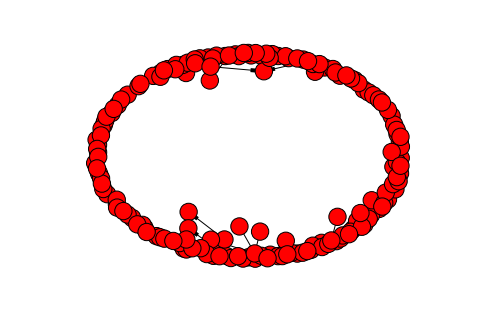

In [131]:
networkx.draw_spring(graph, with_labels=False)
plt.draw()

In [126]:
LKIF_TO_YAGO = {
    'Decree': [u'wordnet_prohibition_106542047', u'wordnet_decree_106539770'],
    'Proclamation': [u'wordnet_proclamation_101266491'],
    'Public_Body': [u'wordnet_court_108329453'],
    'Regulation': [
        u'wordnet_law_106532330', u'wordnet_legal_code_106667792', u'wordnet_legislation_106535222',
        u'wordnet_law_108441203'],
    'Immunity': [u'wordnet_exemption_100213903'],
    'Foundation': [u'wordnet_foundation_108406486'],
    'Permission': [u'wordnet_permission_106689297'],
    'Company': [u'wordnet_company_108058098'],
    'Prohibition': [u'wordnet_prohibition_106542047', u'wordnet_ban_107255401', u'wordnet_interdiction_107255299'],
    'Liability_Right': [u'wordnet_indebtedness_114490319'],
    'Legal_Doctrine': [u'wordnet_common_law_108453722', u'wordnet_case_law_106535035'],
    'Legal_Document': [
        u'wordnet_written_agreement_106771653', u'wordnet_criminal_record_106490173',
        u'wordnet_mandate_106556481', u'wordnet_legal_document_106479665'],
    'Corporation': [u'wordnet_corporation_108059412'],
    'Legislative_Body': [u'wordnet_legislature_108163273'],
    'Permissive_Right': [u'wordnet_authorization_101138670'],
    'Statute': [u'wordnet_legislative_act_106564387'],
    'Limited_Company': [u'wordnet_limited_company_108185211'],
    'Legal_Speech_Act': [u'wordnet_pleading_106559365'],
    'Contract': [u'wordnet_contract_106520944'],
    'Treaty': [u'wordnet_treaty_106773434'],
    'Legal_Role': [u'wordnet_party_110402824'],
    'Liberty_Right': [
        u'wordnet_privilege_105179567', u'wordnet_liberty_113996061', u'wordnet_prerogative_105178715',
        u'wordnet_civil_liberty_113995662', u'wordnet_privilege_105158296', u'wordnet_liberty_113994456'],
    'Obligation': [u'wordnet_obligation_106773150'],
    'Right': [u'wordnet_right_104850341', u'wordnet_right_105174653'],
    'Professional_Legal_Role': [
        u'wordnet_judge_110225219', u'wordnet_lawyer_110249950',
        u'wordnet_judiciary_108166187'],
    'Delegation': [u'wordnet_delegating_101140839'],
    'Society': [u'wordnet_association_108049401'],
    'Potestative_Right': [u'wordnet_right_113341756'],
    'Code_of_Conduct': [u'wordnet_code_of_conduct_105668095'],
}

In [127]:
def get_successors(graph, node):
    result = {}
    if not node in graph:
        print 'Weird, node {} not in graph'.format(node)
        return result
    for successor in graph.successors(node):
        result[successor] = get_successors(graph, successor)
    return result

In [128]:
subontology = defaultdict(dict)
for lkif_class, yago_classes in LKIF_TO_YAGO.iteritems():
    for yago_class in yago_classes:
        subontology[lkif_class][yago_class] = get_successors(graph, yago_class)

In [129]:
dict(subontology)

{'Code_of_Conduct': {u'wordnet_code_of_conduct_105668095': {}},
 'Company': {u'wordnet_company_108058098': {u'wordnet_broadcasting_company_108002015': {},
   u'wordnet_dot-com_108002384': {},
   u'wordnet_drug_company_108002578': {},
   u'wordnet_electronics_company_108003035': {},
   u'wordnet_film_company_108003173': {},
   u'wordnet_food_company_108003427': {},
   u'wordnet_furniture_company_108003525': {},
   u'wordnet_holding_company_108185369': {},
   u'wordnet_livery_company_108186898': {},
   u'wordnet_mining_company_108003619': {},
   u'wordnet_mover_108478482': {},
   u'wordnet_oil_company_108069241': {},
   u'wordnet_packaging_company_108069342': {},
   u'wordnet_pipeline_company_108069487': {},
   u'wordnet_printing_concern_108069627': {},
   u'wordnet_service_108186047': {u'wordnet_utility_108185758': {u'wordnet_bus_company_108186761': {},
     u'wordnet_gas_company_108186655': {},
     u'wordnet_power_company_108186393': {},
     u'wordnet_telephone_company_108186221': {}

In [9]:
networkx.topological_sort(graph)

['wordnet_proclamation_101266491',
 'wordnet_legislature_108163273',
 'wordnet_authorization_101138670',
 'wordnet_legal_document_106479665',
 u'wordnet_act_106532095',
 'wordnet_decree_106539770',
 'wordnet_liability_114530403',
 'wordnet_judge_110225219',
 u'wordnet_ordinary_110382380',
 u'wordnet_praetor_110463028',
 'wordnet_permission_106689297',
 u'wordnet_pass_106691083',
 'wordnet_law_108441203',
 'wordnet_law_106532330',
 u'wordnet_fundamental_law_106533648',
 'wordnet_company_108058098',
 u'wordnet_dot-com_108002384',
 u'wordnet_mining_company_108003619',
 u'wordnet_mover_108478482',
 'wordnet_party_110402824',
 'wordnet_civil_liberty_113995662',
 u'wordnet_packaging_company_108069342',
 u'wordnet_civil_law_108453464',
 u'wordnet_license_106549661',
 'wordnet_common_law_108453722',
 'wordnet_ban_107255401',
 u'wordnet_livery_company_108186898',
 'wordnet_judiciary_108166187',
 'wordnet_limited_company_108185211',
 'wordnet_privilege_105179567',
 'wordnet_pleading_106559365',


In [10]:
graph.successors('wordnet_writ_106552984')

[u'wordnet_warrant_106547059', u'wordnet_court_order_106539502']